<a href="https://colab.research.google.com/github/Lambda-School-Labs/bridges-to-prosperity-ds-d/blob/SMOTE_model_building%2Ftrevor/notebooks/Modeling_off_original_data_smote_gridsearchcv.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook is for problem 2 as described in `B2P Dataset_2020.10.xlsx` Contextual Summary tab:

## Problem 2: Predicting which sites will be technically rejected in future engineering reviews

> Any sites with a "Yes" in the column AQ (`Senior Engineering Review Conducted`) have undergone a full technical review, and of those, the Stage (column L) can be considered to be correct. (`Bridge Opportunity: Stage`)

> Any sites without a "Yes" in Column AQ (`Senior Engineering Review Conducted`) have not undergone a full technical review, and the Stage is based on the assessor's initial estimate as to whether the site was technically feasible or not. 

> We want to know if we can use the sites that have been reviewed to understand which of the sites that haven't yet been reviewed are likely to be rejected by the senior engineering team. 

> Any of the data can be used, but our guess is that Estimated Span, Height Differential Between Banks, Created By, and Flag for Rejection are likely to be the most reliable predictors.


### Load the data

In [2]:
import pandas as pd
url = 'https://github.com/Lambda-School-Labs/bridges-to-prosperity-ds-d/blob/main/Data/B2P%20Dataset_2020.10.xlsx?raw=true'
df = pd.read_excel(url, sheet_name='Data')

### Define the target

In [3]:
# Any sites with a "Yes" in the column "Senior Engineering Review Conducted"
# have undergone a full technical review, and of those, the 
# "Bridge Opportunity: Stage" column can be considered to be correct.
positive = (
    (df['Senior Engineering Review Conducted']=='Yes') & 
    (df['Bridge Opportunity: Stage'].isin(['Complete', 'Prospecting', 'Confirmed']))
)

negative = (
    (df['Senior Engineering Review Conducted']=='Yes') & 
    (df['Bridge Opportunity: Stage'].isin(['Rejected', 'Cancelled']))
)

# Any sites without a "Yes" in column Senior Engineering Review Conducted" 
# have not undergone a full technical review ...
# So these sites are unknown and unlabeled
unknown = df['Senior Engineering Review Conducted'].isna()

# Create a new column named "Good Site." This is the target to predict.
# Assign a 1 for the positive class and 0 for the negative class.
df.loc[positive, 'Good Site'] = 1
df.loc[negative, 'Good Site'] = 0

# Assign -1 for unknown/unlabled observations. 
# Scikit-learn's documentation for "Semi-Supervised Learning" says, 
# "It is important to assign an identifier to unlabeled points ...
# The identifier that this implementation uses is the integer value -1."
# We'll explain this soon!
df.loc[unknown, 'Good Site'] = -1

### Drop columns used to derive the target

In [4]:
# Because these columns were used to derive the target, 
# We can't use them as features, or it would be leakage.
df = df.drop(columns=['Senior Engineering Review Conducted', 'Bridge Opportunity: Stage'])

### Look at target's distribution

In [5]:
df['Good Site'].value_counts()

-1.0    1383
 1.0      65
 0.0      24
Name: Good Site, dtype: int64

So we have 65 labeled observations for the positive class, 24 labeled observations for the negative class, and almost 1,400 unlabeled observations.

### 4 recommendations:

- Use **semi-supervised learning**, which "combines a small amount of labeled data with a large amount of unlabeled data". See Wikipedia notes below. Python implementations are available in [scikit-learn](https://scikit-learn.org/stable/modules/label_propagation.html) and [pomegranate](https://pomegranate.readthedocs.io/en/latest/semisupervised.html). Another way to get started: feature engineering + feature selection + K-Means Clustering + PCA in 2 dimensions. Then visualize the clusters on a scatterplot, with colors for the labels.
- Use [**leave-one-out cross-validation**](https://en.wikipedia.org/wiki/Cross-validation_(statistics)#Leave-one-out_cross-validation), without an independent test set, because we have so few labeled observations. It's implemented in [scikit-learn](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneOut.html). Or maybe 10-fold cross-validation with stratified sampling (and no independent test set).
- Consider **"over-sampling"** techniques for imbalanced classification. Python implementations are available in [imbalanced-learn](https://github.com/scikit-learn-contrib/imbalanced-learn).
- Consider using [**Snorkel**](https://www.snorkel.org/) to write "labeling functions" for "weakly supervised learning." The site has many [tutorials](https://www.snorkel.org/use-cases/). 



### [Semi-supervised learning - Wikipedia](https://en.wikipedia.org/wiki/Semi-supervised_learning)

> Semi-supervised learning is an approach to machine learning that combines a small amount of labeled data with a large amount of unlabeled data during training. Semi-supervised learning falls between unsupervised learning (with no labeled training data) and supervised learning (with only labeled training data).

> Unlabeled data, when used in conjunction with a small amount of labeled data, can produce considerable improvement in learning accuracy. The acquisition of labeled data for a learning problem often requires a skilled human agent ... The cost associated with the labeling process thus may render large, fully labeled training sets infeasible, whereas acquisition of unlabeled data is relatively inexpensive. In such situations, semi-supervised learning can be of great practical value.

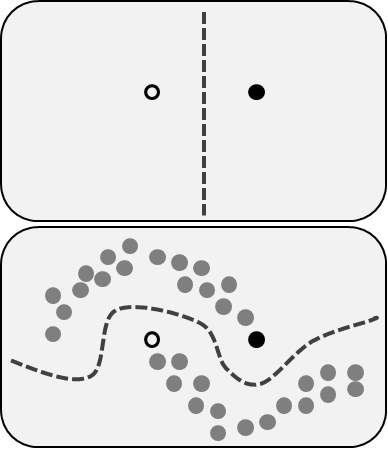

> An example of the influence of unlabeled data in semi-supervised learning. The top panel shows a decision boundary we might adopt after seeing only one positive (white circle) and one negative (black circle) example. The bottom panel shows a decision boundary we might adopt if, in addition to the two labeled examples, we were given a collection of unlabeled data (gray circles). This could be viewed as performing clustering and then labeling the clusters with the labeled data, pushing the decision boundary away from high-density regions ...

See also:

- “Positive-Unlabeled Learning”
- https://en.wikipedia.org/wiki/One-class_classification

# Model attempt - Smaller Dataset Not utilizing world data

- Here I am attempting to build a model using less "created" data than we did in previous attempts using the world data set. This had more successful bridge builds but those bridge builds did not include pertainant feature for building a predictive model. 

In [ ]:
df.info()

In [11]:
# Columns suggeested bt stakeholder to utilize while model building
keep_list = ['Bridge Opportunity: Span (m)',
             'Bridge Opportunity: Individuals Directly Served', 
             'Form: Created By',
             'Height differential between banks', 'Flag for Rejection',
             'Good Site']


In [12]:
# isolating the dataset to just the modelset
modelset = df[keep_list]

modelset.head()

,Bridge Opportunity: Span (m),Bridge Opportunity: Individuals Directly Served,Form: Created By,Height differential between banks,Flag for Rejection,Good Site
0,NaN,NaN,aimablengirabakunzi taroworks,NaN,Yes,0.0
1,48.0,4000.0,Stephanie May,0.7,NaN,1.0
2,50.0,12500.0,etiennemutebutsi taroworks,1.0,NaN,1.0
3,68.0,4363.0,aimablengirabakunzi taroworks,1.1,No,1.0
4,78.0,2790.0,dominiquehabimana taroworks,1.1,No,1.0


In [13]:
# built modelset based off of original dataset - not much cleaning here.
# further cleaning could be an area for improvement.  
modelset['Good Site'].value_counts()

-1.0    1383
 1.0      65
 0.0      24
Name: Good Site, dtype: int64

In [14]:
!pip install category_encoders

     |████████████████████████████████| 81kB 6.7MB/s 


In [15]:
# Imports:
from collections import Counter
from sklearn.pipeline import make_pipeline
from imblearn.pipeline import make_pipeline as make_pipeline_imb
from imblearn.over_sampling import SMOTE
from imblearn.metrics import classification_report_imbalanced
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, accuracy_score, classification_report

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be import

In [21]:
# split data - intial split eliminated all of the "unlabeled" sites 
data = modelset[(modelset['Good Site']== 0) | (modelset['Good Site']== 1)]
test = modelset[modelset['Good Site']== -1]

train, val = train_test_split(data, test_size=.2, random_state=42)


In [22]:
# splitting our labeled sites into a train and validation set for model building

X_train = train.drop('Good Site', axis=1)
y_train = train['Good Site']
X_val = val.drop('Good Site', axis=1)
y_val = val['Good Site']

X_train.shape, y_train.shape, X_val.shape, y_val.shape

((71, 5), (71,), (18, 5), (18,))

In [30]:
# Building a base model without SMOTE

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

kf = KFold(n_splits=5, shuffle=False)

base_pipe = make_pipeline(ce.OrdinalEncoder(),
                        SimpleImputer(strategy = 'mean'),
                        RandomForestClassifier(n_estimators=100, random_state=42))
cross_val_score(base_pipe, X_train, y_train, cv=kf, scoring='precision')


array([0.75      , 0.91666667, 0.9       , 0.75      , 0.83333333])

From the results above we can see the variety of the precision scores, looks like we have some overfit values when it comes to different cross validations

In [42]:
# use of imb_learn pipeline
imba_pipe = make_pipeline_imb(ce.OrdinalEncoder(),
                              SimpleImputer(strategy = 'mean'),
                              SMOTE(random_state=42),
                              RandomForestClassifier(n_estimators=100, random_state=42))

cross_val_score(imba_pipe, X_train, y_train, cv=kf, scoring='precision')


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

array([0.75      , 1.        , 0.875     , 0.625     , 0.88888889])

Using an imbalanced Pipeline with SMOTE we still see the large variety in precision 1.0 as a high and .625 as a low. 


In [ ]:
# using grid search to attempt to further validate the model to use on predicitions

new_params = {'randomforestclassifier__n_estimators': [100, 200, 50],
              'randomforestclassifier__max_depth': [4, 6, 10, 12], 
              'simpleimputer__strategy': ['mean', 'median']
}

imba_grid_1 = GridSearchCV(imba_pipe, param_grid=new_params, cv=kf, 
                        scoring='precision',
                        return_train_score=True)
imba_grid_1.fit(X_train, y_train);


In [48]:
# Params used and best score on a basis of precision

print(imba_grid_1.best_params_, imba_grid_1.best_score_)


{'randomforestclassifier__max_depth': 4, 'randomforestclassifier__n_estimators': 100, 'simpleimputer__strategy': 'median'} 0.8527777777777779


In [55]:
# Working with more folds for validation

more_kf = KFold(n_splits=15)

imba_grid_2 = GridSearchCV(imba_pipe, param_grid=new_params, cv=more_kf, 
                        scoring='precision',
                        return_train_score=True)
imba_grid_2.fit(X_train, y_train);

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

In [56]:
print(imba_grid_2.best_score_, imba_grid_2.best_estimator_)

0.87 Pipeline(memory=None,
         steps=[('ordinalencoder',
                 OrdinalEncoder(cols=['Form: Created By', 'Flag for Rejection'],
                                drop_invariant=False, handle_missing='value',
                                handle_unknown='value',
                                mapping=[{'col': 'Form: Created By',
                                          'data_type': dtype('O'),
                                          'mapping': graceumumararungu taroworks        1
edouardumwanzuro taroworks         2
etiennemutebutsi taroworks         3
solangeyandereye taroworks         4
aimablen...
                 RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                        class_weight=None, criterion='gini',
                                        max_depth=4, max_features='auto',
                                        max_leaf_nodes=None, max_samples=None,
                                        min_impurity_decrease=0.0,
      

In [57]:
imba_grid_2.cv_results_

# muted output because it was lenghty
# during output we did see a lot of 1s... Is this a sign of overfitting? 

{'mean_fit_time': array([0.13758882, 0.13870254, 0.26055077, 0.2611379 , 0.07692922,
        0.07896733, 0.13935528, 0.14127843, 0.26271207, 0.26523593,
        0.07778962, 0.07791878, 0.13954954, 0.14753316, 0.26982233,
        0.26699177, 0.0775785 , 0.07881786, 0.1411387 , 0.14225494,
        0.26520923, 0.26474209, 0.07852395, 0.07932059]),
 'mean_score_time': array([0.01253055, 0.01195337, 0.01901398, 0.01993937, 0.00846109,
        0.00871191, 0.01181556, 0.01227048, 0.01927183, 0.01923874,
        0.00871526, 0.00847718, 0.01198821, 0.01191201, 0.02068445,
        0.02016184, 0.00893814, 0.00866537, 0.01205443, 0.01199803,
        0.01918763, 0.01978938, 0.00866661, 0.00924981]),
 'mean_test_score': array([0.8       , 0.87      , 0.8       , 0.82555556, 0.82777778,
        0.87      , 0.81666667, 0.82555556, 0.83333333, 0.82555556,
        0.81666667, 0.84777778, 0.83333333, 0.82555556, 0.83333333,
        0.82555556, 0.81666667, 0.81555556, 0.83333333, 0.82555556,
        0.85 

In [58]:
# Now looking to the val set to get some more numbers

y_val_predict = imba_grid_2.predict(X_val)

precision_score(y_val, y_val_predict)

0.9230769230769231

The best score from above was .87, now running the model on the val set, it looks like we end with 92% precision score. 